<a href="https://colab.research.google.com/github/vss121/odyssey-ai/blob/main/%EC%83%89%EA%B9%94%EC%B6%94%EA%B0%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 기본 설정

## 첫 설정

In [42]:
import torch
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import clear_output, display, Image
from collections import defaultdict

## YOLOv5 설치

In [43]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Cloning into 'yolov5'...
remote: Enumerating objects: 16383, done.
remote: Counting objects: 100% (277/277), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 16383 (delta 138), reused 159 (delta 74), pack-reused 16106
Receiving objects: 100% (16383/16383), 15.16 MiB | 20.24 MiB/s, done.
Resolving deltas: 100% (11175/11175), done.
/content/distinctipy/yolov5


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-1-19 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 124MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


## Supervision 설치

In [44]:
!pip install supervision

import supervision as sv

colors = sv.ColorPalette.default()

# 2. 데이터 세팅

## 영상 다운로드

In [45]:
import os
HOME = os.getcwd()
%cd {HOME}

!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1vcKRPpv7ve1St-0rynhGa-H3lHMyCNt9' -O exhibition-64-sample.mp4
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1ERyxsKGZmJZFgOBKGwVguQFqGJbYu575' -O exhibition-32-sample.mp4
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1Mcp8xRYhsaxE3SfGAUaeJk63rNNkx80d' -O exhibition-4-sample.mp4
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1jEhErOcFKt7JrliQFzMar5yerHkTeu09?' -O exhibition-64-full.mp4
!wget --load-cookies /tmp/cookies.txt "https://drive.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1jEhErOcFKt7JrliQFzMar5yerHkTeu09' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1jEhErOcFKt7JrliQFzMar5yerHkTeu09" -O exhibition-64-full.mp4 && rm -rf /tmp/cookies.txt
!wget --load-cookies /tmp/cookies.txt "https://drive.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1WJpbbx-w3QCFVmB0D0892vWVBCWdL3Kn' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1WJpbbx-w3QCFVmB0D0892vWVBCWdL3Kn" -O exhibition-64-test.mp4 && rm -rf /tmp/cookies.txt
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1QSneFB5hw85I9LMf14PHKh8P63kWRryc' -O exhibition-dark-sample.mp4
# !wget --no-check-certificate 'https://googledrive.com/host/exhibition/1jEhErOcFKt7JrliQFzMar5yerHkTeu09' -O exhibition-64-full.mp4

/content/distinctipy/yolov5
--2024-01-19 14:40:47--  https://drive.google.com/uc?export=download&id=1vcKRPpv7ve1St-0rynhGa-H3lHMyCNt9
Resolving drive.google.com (drive.google.com)... 142.251.6.138, 142.251.6.113, 142.251.6.102, ...
Connecting to drive.google.com (drive.google.com)|142.251.6.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1vcKRPpv7ve1St-0rynhGa-H3lHMyCNt9&export=download [following]
--2024-01-19 14:40:47--  https://drive.usercontent.google.com/download?id=1vcKRPpv7ve1St-0rynhGa-H3lHMyCNt9&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.159.132, 2607:f8b0:4001:c58::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.159.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3936497 (3.8M) [video/mp4]
Saving to: ‘exhibition-64-sample.mp4’

exhibition-64-sampl 100%[==================

## 영상 경로 설정

In [46]:
SAMPLE_VIDEO_64 = f"{HOME}/exhibition-64-sample.mp4"
SAMPLE_VIDEO_32 = f"{HOME}/exhibition-32-sample.mp4"
SAMPLE_VIDEO_4 = f"{HOME}/exhibition-4-sample.mp4"
FULL_VIDEO_64 = f"{HOME}/exhibition-64-full.mp4"
TEST_VIDEO_64 = f"{HOME}/exhibition-64-test.mp4"
SAMPLE_VIDEO_DARK = f"{HOME}/exhibition-dark-sample.mp4"

VIDEO = SAMPLE_VIDEO_64

video_info = sv.VideoInfo.from_video_path(VIDEO)

## Polygon 설정

In [47]:
zone_coords = np.array([[378,260],[688,260],[1080,1745],[0,1745]])
polygon = zone_coords

## Annotator 설정

### ZoneAnnotator

Polygon 값에 따라 구역을 표시하는 Annotator

In [48]:
zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=video_info.resolution_wh)

zone_annotator = sv.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(0),
        thickness=8,
        # text_thickness=8,
        # text_scale=4
    )

### BoundingBoxAnnotator

사람을 감싸는 직사각형 박스

In [49]:
bounding_box_annotator = sv.BoundingBoxAnnotator(color=colors.by_idx(0),thickness=6)

### TraceAnnotator

사람의 동선을 따라가는 꼬리

In [50]:
trace_annotator = sv.TraceAnnotator(color=colors.by_idx(0), trace_length=50,thickness=4)

### MaskAnnotator

사람을 덮는 Mask

In [51]:
mask_annotator = sv.MaskAnnotator(color=colors.by_idx(0))

### LabelAnnotator

In [52]:
label_annotator = sv.LabelAnnotator(color=colors.by_idx(0))

# 3. 비디오 분석

In [53]:
# !pip install ffmpeg-python
# import ffmpeg

# def trim_video(input_path, output_path, end_frame, fps=24):
#     """
#     input_path: 입력 비디오 파일 경로
#     output_path: 출력 비디오 파일 경로
#     end_frame: 잘라낼 마지막 프레임 번호
#     fps: 비디오의 프레임 속도 (기본값: 30)
#     """
#     end_time = end_frame / fps  # 마지막 프레임에 해당하는 시간
#     (
#         ffmpeg
#         .input(input_path)
#         .output(output_path, vframes=end_frame, format='mp4')
#         .run(capture_stdout=True, capture_stderr=True)
#     )

# # 사용 예시
# OUTPUT_VIDEO = f"{HOME}/trimmed_video.mp4"
# trim_video(VIDEO, OUTPUT_VIDEO, 7200)  # 예: 첫 1000 프레임만 잘라내기
# VIDEO=OUTPUT_VIDEO


In [54]:
tracker = sv.ByteTrack()

each_coord = []

def add_coordinates(detections, frame_number):
    global each_coord

    each_coord.append([])

    for detection in detections:

      coord = detection[0]

      center_x = int((coord[0] + coord[2]) / 2)
      bottom_y = int(coord[3])

      tracker_id = detection[4]

      each_coord[-1].append((frame_number, tracker_id, center_x, bottom_y))

def process_frame(frame:np.ndarray, i) -> np.ndarray:
    if i % 4 == 0:
      print(f"Processing frame {i}...")

      results = model(frame,size=1280)
      detections = sv.Detections.from_yolov5(results)

      mask = zone.trigger(detections=detections)
      detections = detections[mask]

      detections = detections[(detections.class_id == 0) & (detections.confidence > 0.2)]
      detections = tracker.update_with_detections(detections)

      labels = [
          str(tracker_id)
          for tracker_id
          in detections.tracker_id
      ]

      # print(detections)

      frame = zone_annotator.annotate(scene=frame.copy())
      frame = bounding_box_annotator.annotate(scene=frame.copy(), detections=detections)
      frame = trace_annotator.annotate(scene=frame.copy(), detections=detections)
      frame = mask_annotator.annotate(scene=frame.copy(), detections=detections)
      frame = label_annotator.annotate(scene=frame.copy(), detections=detections, labels=labels)

      # if i % 4 == 0:
        # add_coordinates(detections, i)
      add_coordinates(detections, i)


      # 실시간으로 프레임 출력
      # clear_output(wait=True)
      # _, buffer = cv2.imencode('.jpg', frame)
      # display(Image(data=buffer.tobytes()))

      return frame


sv.process_video(source_path=VIDEO, target_path=f"{HOME}/result.mp4",callback=process_frame)

for coords in each_coord:
  print(coords)

Processing frame 0...
Processing frame 4...
Processing frame 8...
Processing frame 12...
Processing frame 16...
Processing frame 20...
Processing frame 24...
Processing frame 28...
Processing frame 32...
Processing frame 36...
Processing frame 40...
Processing frame 44...
Processing frame 48...
Processing frame 52...
Processing frame 56...
Processing frame 60...
Processing frame 64...
Processing frame 68...
Processing frame 72...
Processing frame 76...
Processing frame 80...
Processing frame 84...
Processing frame 88...
Processing frame 92...
Processing frame 96...
Processing frame 100...
Processing frame 104...
Processing frame 108...
Processing frame 112...
Processing frame 116...
Processing frame 120...
Processing frame 124...
Processing frame 128...
Processing frame 132...
Processing frame 136...
Processing frame 140...
Processing frame 144...
Processing frame 148...
Processing frame 152...
Processing frame 156...
Processing frame 160...
Processing frame 164...
Processing frame 168

# 데이터 분석

## 오래 머무른 id값 제거

In [55]:
frame_rate = 24
frames_per_record = 4
one_minute_frames = (1 * 60 * frame_rate) / frames_per_record
threshold_distance = 2000  # 1분 동안 이동한 거리의 임계값
object_data = {}
stationary_ids = set()

for frame_data in each_coord:
    for coord in frame_data:
        frame, obj_id, x, y = coord

        if obj_id not in object_data:
            object_data[obj_id] = {'frame': frame, 'last_x': x, 'last_y': y, 'total_distance': 0}
        else:
            data = object_data[obj_id]
            distance = ((x - data['last_x']) ** 2 + (y - data['last_y']) ** 2) ** 0.5
            data['total_distance'] += distance

            if (frame - data['frame']) >= one_minute_frames:
                if data['total_distance'] < threshold_distance:
                    stationary_ids.add(obj_id)
                data['frame'] = frame
                data['total_distance'] = 0
            data['last_x'], data['last_y'] = x, y

unique_ids = set()

for frame_data in each_coord:
    for coord in frame_data:
        obj_id = coord[1]
        unique_ids.add(obj_id)

print("전체 고유 ID 개수:", len(unique_ids))
print(len(stationary_ids))

filtered_each_coord = []

for frame_data in each_coord:
    filtered_frame_data = [coord for coord in frame_data if coord[1] not in stationary_ids]
    filtered_each_coord.append(filtered_frame_data)

print(filtered_each_coord)



전체 고유 ID 개수: 26
0
[[(0, 28, 624, 1023), (0, 29, 293, 1712), (0, 30, 575, 490), (0, 31, 544, 433), (0, 32, 602, 684), (0, 33, 459, 324), (0, 34, 496, 893), (0, 35, 586, 779), (0, 36, 542, 1077), (0, 37, 276, 974), (0, 38, 355, 956), (0, 39, 414, 1555), (0, 40, 383, 542), (0, 41, 273, 1215), (0, 42, 344, 1144), (0, 43, 562, 1280)], [(4, 28, 615, 993), (4, 29, 289, 1706), (4, 30, 574, 491), (4, 31, 536, 442), (4, 32, 605, 686), (4, 34, 479, 886), (4, 35, 581, 777), (4, 36, 545, 1053), (4, 37, 275, 979), (4, 38, 355, 959), (4, 39, 411, 1552), (4, 40, 382, 542), (4, 41, 273, 1210), (4, 42, 342, 1142), (4, 43, 558, 1281)], [(8, 28, 604, 985), (8, 29, 289, 1707), (8, 30, 574, 487), (8, 31, 531, 445), (8, 32, 607, 689), (8, 34, 473, 884), (8, 35, 581, 776), (8, 36, 549, 1047), (8, 37, 276, 982), (8, 38, 355, 958), (8, 39, 411, 1554), (8, 40, 383, 543), (8, 41, 273, 1212), (8, 42, 348, 1144), (8, 43, 553, 1278), (8, 44, 487, 325)], [(12, 28, 601, 980), (12, 29, 277, 1704), (12, 30, 573, 486), (

## 초기값 설정

In [56]:
width = 400
height = 2000

## 좌표 변환

In [57]:
# 원근 변환을 위한 소스 및 대상 점 정의
src_points = np.float32([[378,260],[688,260],[1080,1745],[0,1745]])
dst_points = np.float32([[0, 0], [width, 0], [width, height], [0, height]])

# 원근 변환 행렬 계산
M = cv2.getPerspectiveTransform(src_points, dst_points)

# 비디오를 로드
cap = cv2.VideoCapture(VIDEO)

# 첫 프레임을 읽기
ret, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
warped_image = cv2.warpPerspective(frame, M, (width, height))

# 객체별 경로를 저장할 defaultdict 생성
trajectories = defaultdict(list)

for frame_coords in filtered_each_coord:
  for coord in frame_coords:
    frame,obj_id, x,y = coord
    # 좌표에 원근 변환 적용
    transformed_coord = cv2.perspectiveTransform(np.array([[x, y]], dtype='float32').reshape(-1, 1, 2), M)
    # 변환된 좌표를 객체 ID에 맞게 리스트에 추가
    trajectories[obj_id].append((frame, transformed_coord[0][0][0], transformed_coord[0][0][1]))

# 출력

## 이동경로 출력

In [58]:
%cd ..
!git clone https://github.com/alan-turing-institute/distinctipy.git
%cd distinctipy
!pip install .

/content/distinctipy
fatal: destination path 'distinctipy' already exists and is not an empty directory.
/content/distinctipy/distinctipy
ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


[(0.0, 1.0, 0.0), (1.0, 0.0, 1.0), (0.0, 0.5, 1.0), (1.0, 0.5, 0.0), (0.5, 0.75, 0.5), (0.3061532909280057, 0.02215695185835964, 0.6542393993624759), (0.761968262009651, 0.006317366715795969, 0.13090658917610454), (0.0, 1.0, 1.0), (0.8253163696963817, 0.48991154886292065, 0.9512907727376999), (1.0, 1.0, 0.0), (0.09837746879312259, 0.4938892810422767, 0.07442100488831649), (0.0, 1.0, 0.5), (0.0055186830951468036, 0.36784717778914855, 0.5340096505949339), (0.6367596792784859, 0.35715097950393493, 0.42984654744500916), (0.9910507447020364, 0.7334391005826105, 0.5849052079337381), (0.5334322661834305, 0.8106088744288473, 0.9909065286313383), (0.5632532199970608, 0.6504944657485662, 0.018262586826747307), (0.0, 0.0, 1.0), (0.5365521943612549, 0.21489153813256223, 0.9892562380030215), (0.5, 1.0, 0.0), (0.4315317708425269, 0.2439955892528548, 0.03419021621702878), (1.0, 0.0, 0.5), (0.801231276532708, 0.9778172210901819, 0.38390012049236244), (0.3449606027662112, 0.5054318992721546, 0.74559866

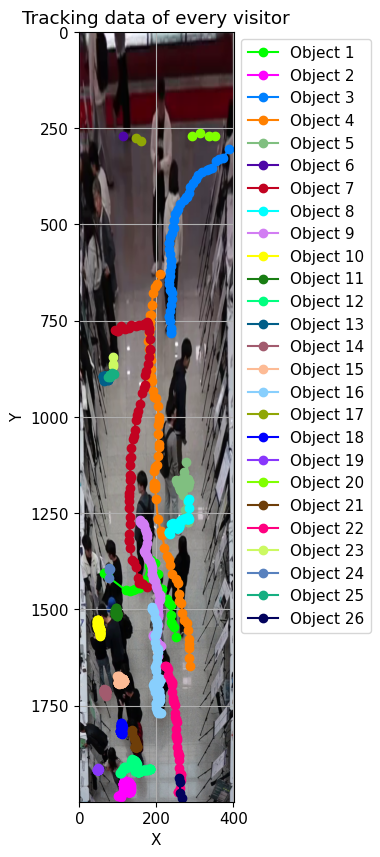

In [59]:
# id 개수
trajectories_items_num = len(trajectories.items())

# distinctipy 라이브러리 사용
from distinctipy import distinctipy
colors = distinctipy.get_colors(trajectories_items_num)
print(colors)

# 색깔 확인
# distinctipy.color_swatch(colors)

# 개수 세기
trajectories_items_num = 0

# 각 객체별로 정렬된 좌표에 따라 경로 그리기
plt.figure(figsize=(2, 10))
for obj_id, path in trajectories.items():
    # 개수 +1
    trajectories_items_num += 1
    # 시간에 따라 경로 정렬
    sorted_path = sorted(path, key=lambda x: x[0])
    # 경로의 x, y 좌표를 분리
    x_coords, y_coords = zip(*[(x, y) for _, x, y in sorted_path])

    # 경로를 그림
    # plt.plot(x_coords, y_coords, marker='o', label=f'Object {obj_id}')
    plt.plot(x_coords, y_coords, color=colors[trajectories_items_num - 1], marker='o', label=f'Object {trajectories_items_num}')

# 시각화 설정
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # 범례

plt.imshow(warped_image)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Tracking data of every visitor')
plt.xlim([0, width])
plt.ylim([height, 0])
plt.grid(True)
plt.axis('equal')  # 축의 스케일을 동일하게 설정

# 결과 표시
plt.show()


## 히트맵 출력

### 밀도 계산

In [60]:
coords = []
for obj_id, path in trajectories.items():
    for frame, x, y in path:
        coords.append((x, y))
x, y = zip(*coords)

# 그리드 크기와 커널 반경
grid_size = 1
h = 50

# 그리드 설정
x_grid = np.arange(0, width+1, grid_size)
y_grid = np.arange(0, height+1, grid_size)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

def kde_quartic(d, h):
    dn = d / h
    P = (15 / 16) * (1 - dn ** 2) ** 2
    return np.where(dn <= 1, P, 0)

# 밀도 계산을 위한 Numpy 배열 연산 최적화
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)
intensity_list = np.zeros_like(x_mesh, dtype=np.float64)

# 각 좌표에 대해 한 번에 계산
for i in range(len(x)):
    d_squared = (x_mesh - x[i])**2 + (y_mesh - y[i])**2
    d = np.sqrt(d_squared)
    p = kde_quartic(d, h)
    intensity_list += p

출력

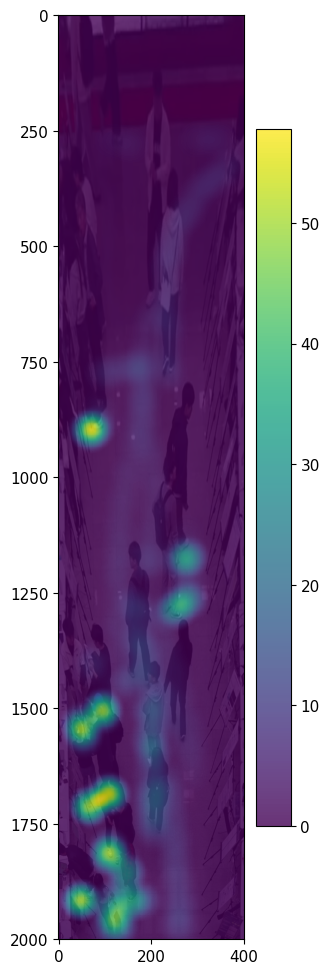

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt

# 결과 시각화
intensity = np.array(intensity_list)
plt.figure(figsize=(3, 12))
plt.imshow(warped_image)
plt.axis('equal')  # 축의 스케일을 동일하게 설정
plt.pcolormesh(x_mesh, y_mesh, intensity, shading='auto', alpha=0.8)
# plt.plot(x, y, 'ro')
plt.xlim([0,width])
plt.ylim([height,0])
plt.colorbar()
plt.show()

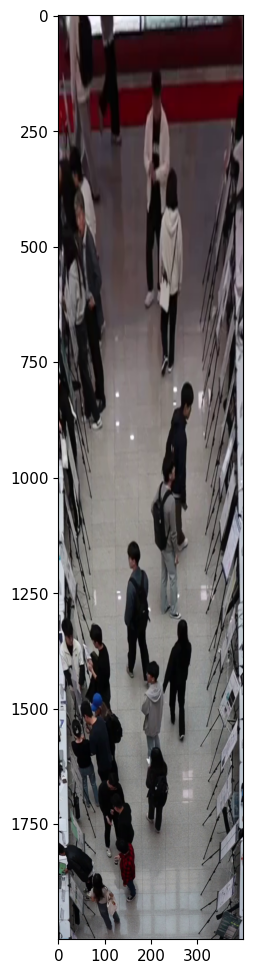

In [62]:
plt.figure(figsize=(3, 12))
plt.imshow(warped_image)
plt.show()